In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import sys

sys.path.insert(1, str(Path().cwd().parent))
import common_config

In [2]:
common_config.figure_journal_basic()

In [3]:
import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pickle as pkl

In [4]:
with open("dialogue_output/dialogue_lp.pkl", "rb") as file:
    dlg_lp_results = pkl.load(file)

In [5]:
dlg_lp_results.keys()

dict_keys(['mcps', 'ws', 'ct_subs', 'pvals', 'pvals_adj', 'tstats'])

In [6]:
associations_df = dlg_lp_results["pvals_adj"]

In [7]:
adata = ad.read_h5ad("dialogue_output/dialogue_lp.h5ad")
adata

AnnData object with n_obs × n_vars = 42550 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'n_counts', 'Number of genes', 'Major celltype', 'Cluster', 'mcp_0', 'mcp_1', 'mcp_2', 'mcp_3', 'mcp_4', 'mcp_5', 'mcp_6', 'mcp_7', 'mcp_8', 'mcp_9'
    obsm: 'X_pca', 'X_umap'

In [8]:
associations_df.index

CategoricalIndex(['t_Bmem-CD27', 't_CD4_Tcm-LMNA', 't_CD4_Treg-FOXP3',
                  't_CD8_MAIT-KLRB1', 't_CD8_Tem-GZMK', 't_CD8_Trm-ZNF683',
                  't_Tn-LEF1', 't_mono-FCN1', 't_pB-IGHG1'],
                 categories=['t_Bmem-CD27', 't_CD4_Tcm-LMNA', 't_CD4_Treg-FOXP3', 't_CD8_MAIT-KLRB1', ..., 't_CD8_Trm-ZNF683', 't_Tn-LEF1', 't_mono-FCN1', 't_pB-IGHG1'], ordered=False, dtype='category')

# Heatmap of MCPs

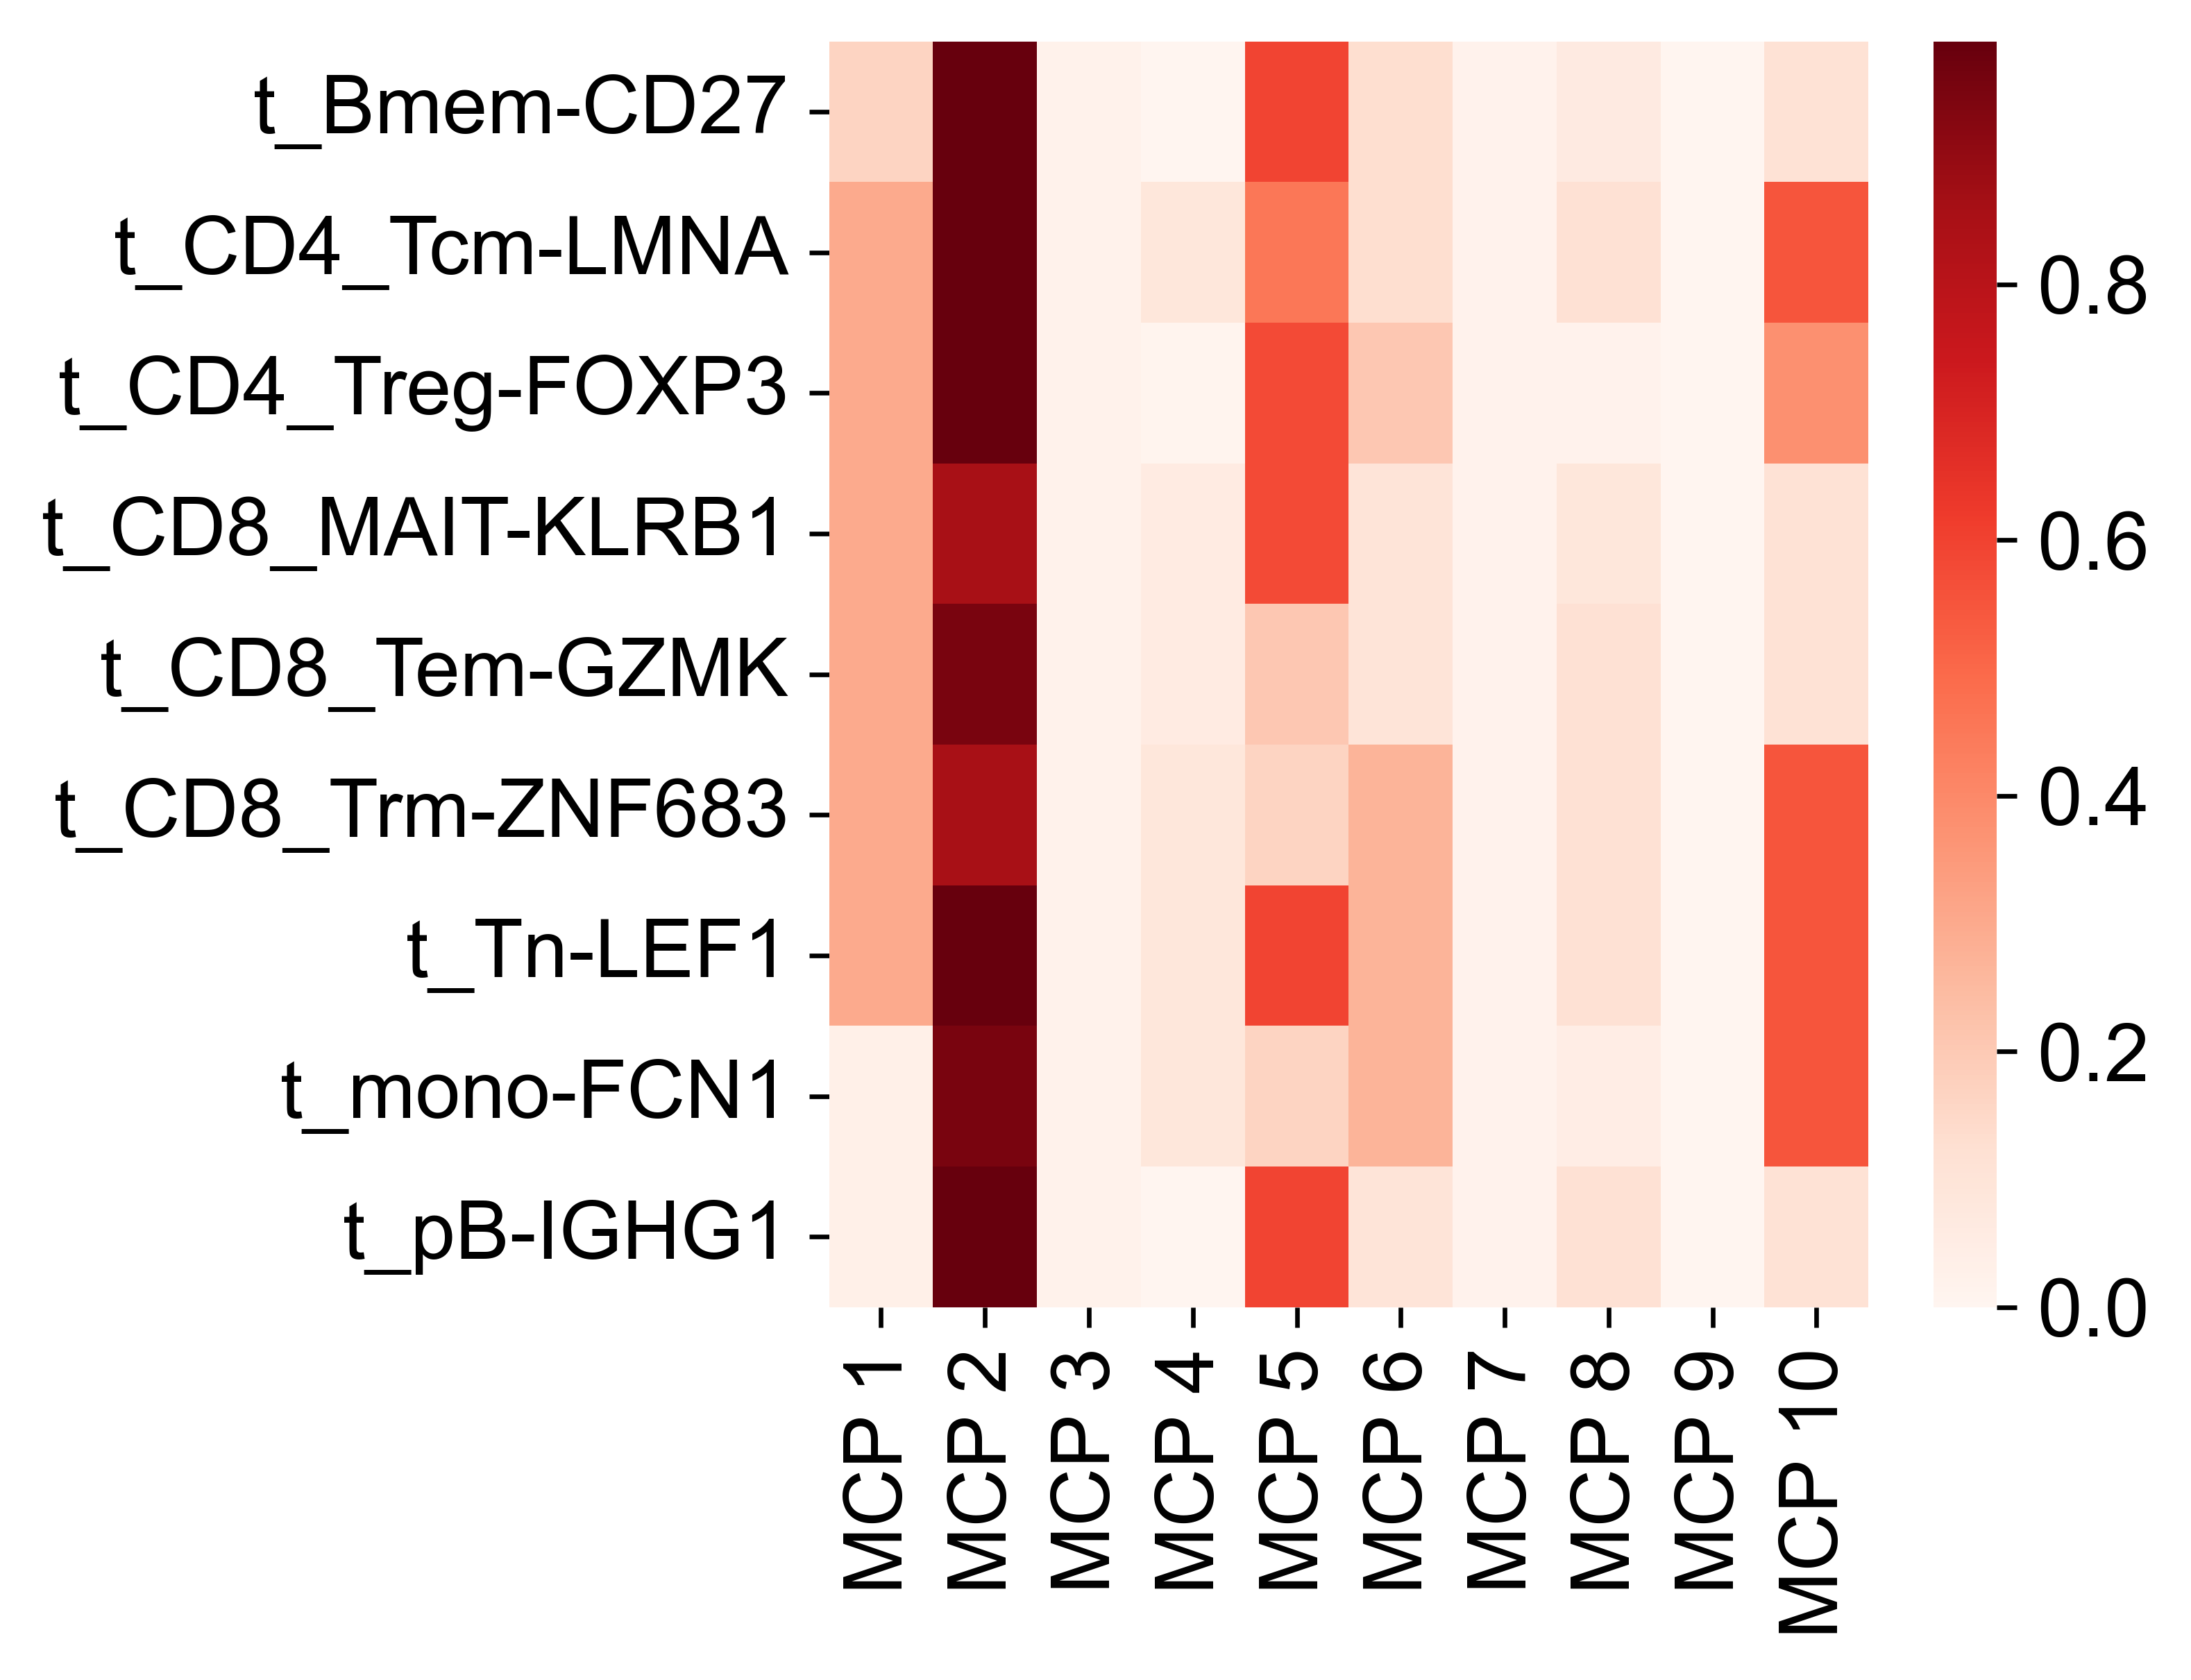

In [10]:
log_associations_df = associations_df.copy()
for mcp_nr in range(10):
    log_associations_df[f"MCP {mcp_nr + 1}"] = -1 * np.log10(log_associations_df[f"mcp_{mcp_nr}"])
log_associations_df = log_associations_df.drop(columns=[f"mcp_{mcp_nr}" for mcp_nr in range(10)])

plt.figure(figsize=(4, 4))
sns.heatmap(log_associations_df, vmin=0, cbar=True, cmap="Reds")

plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)

plt.savefig("figures/mcp_heatmap.pdf", bbox_inches="tight")

# Pairplots for MCP 2

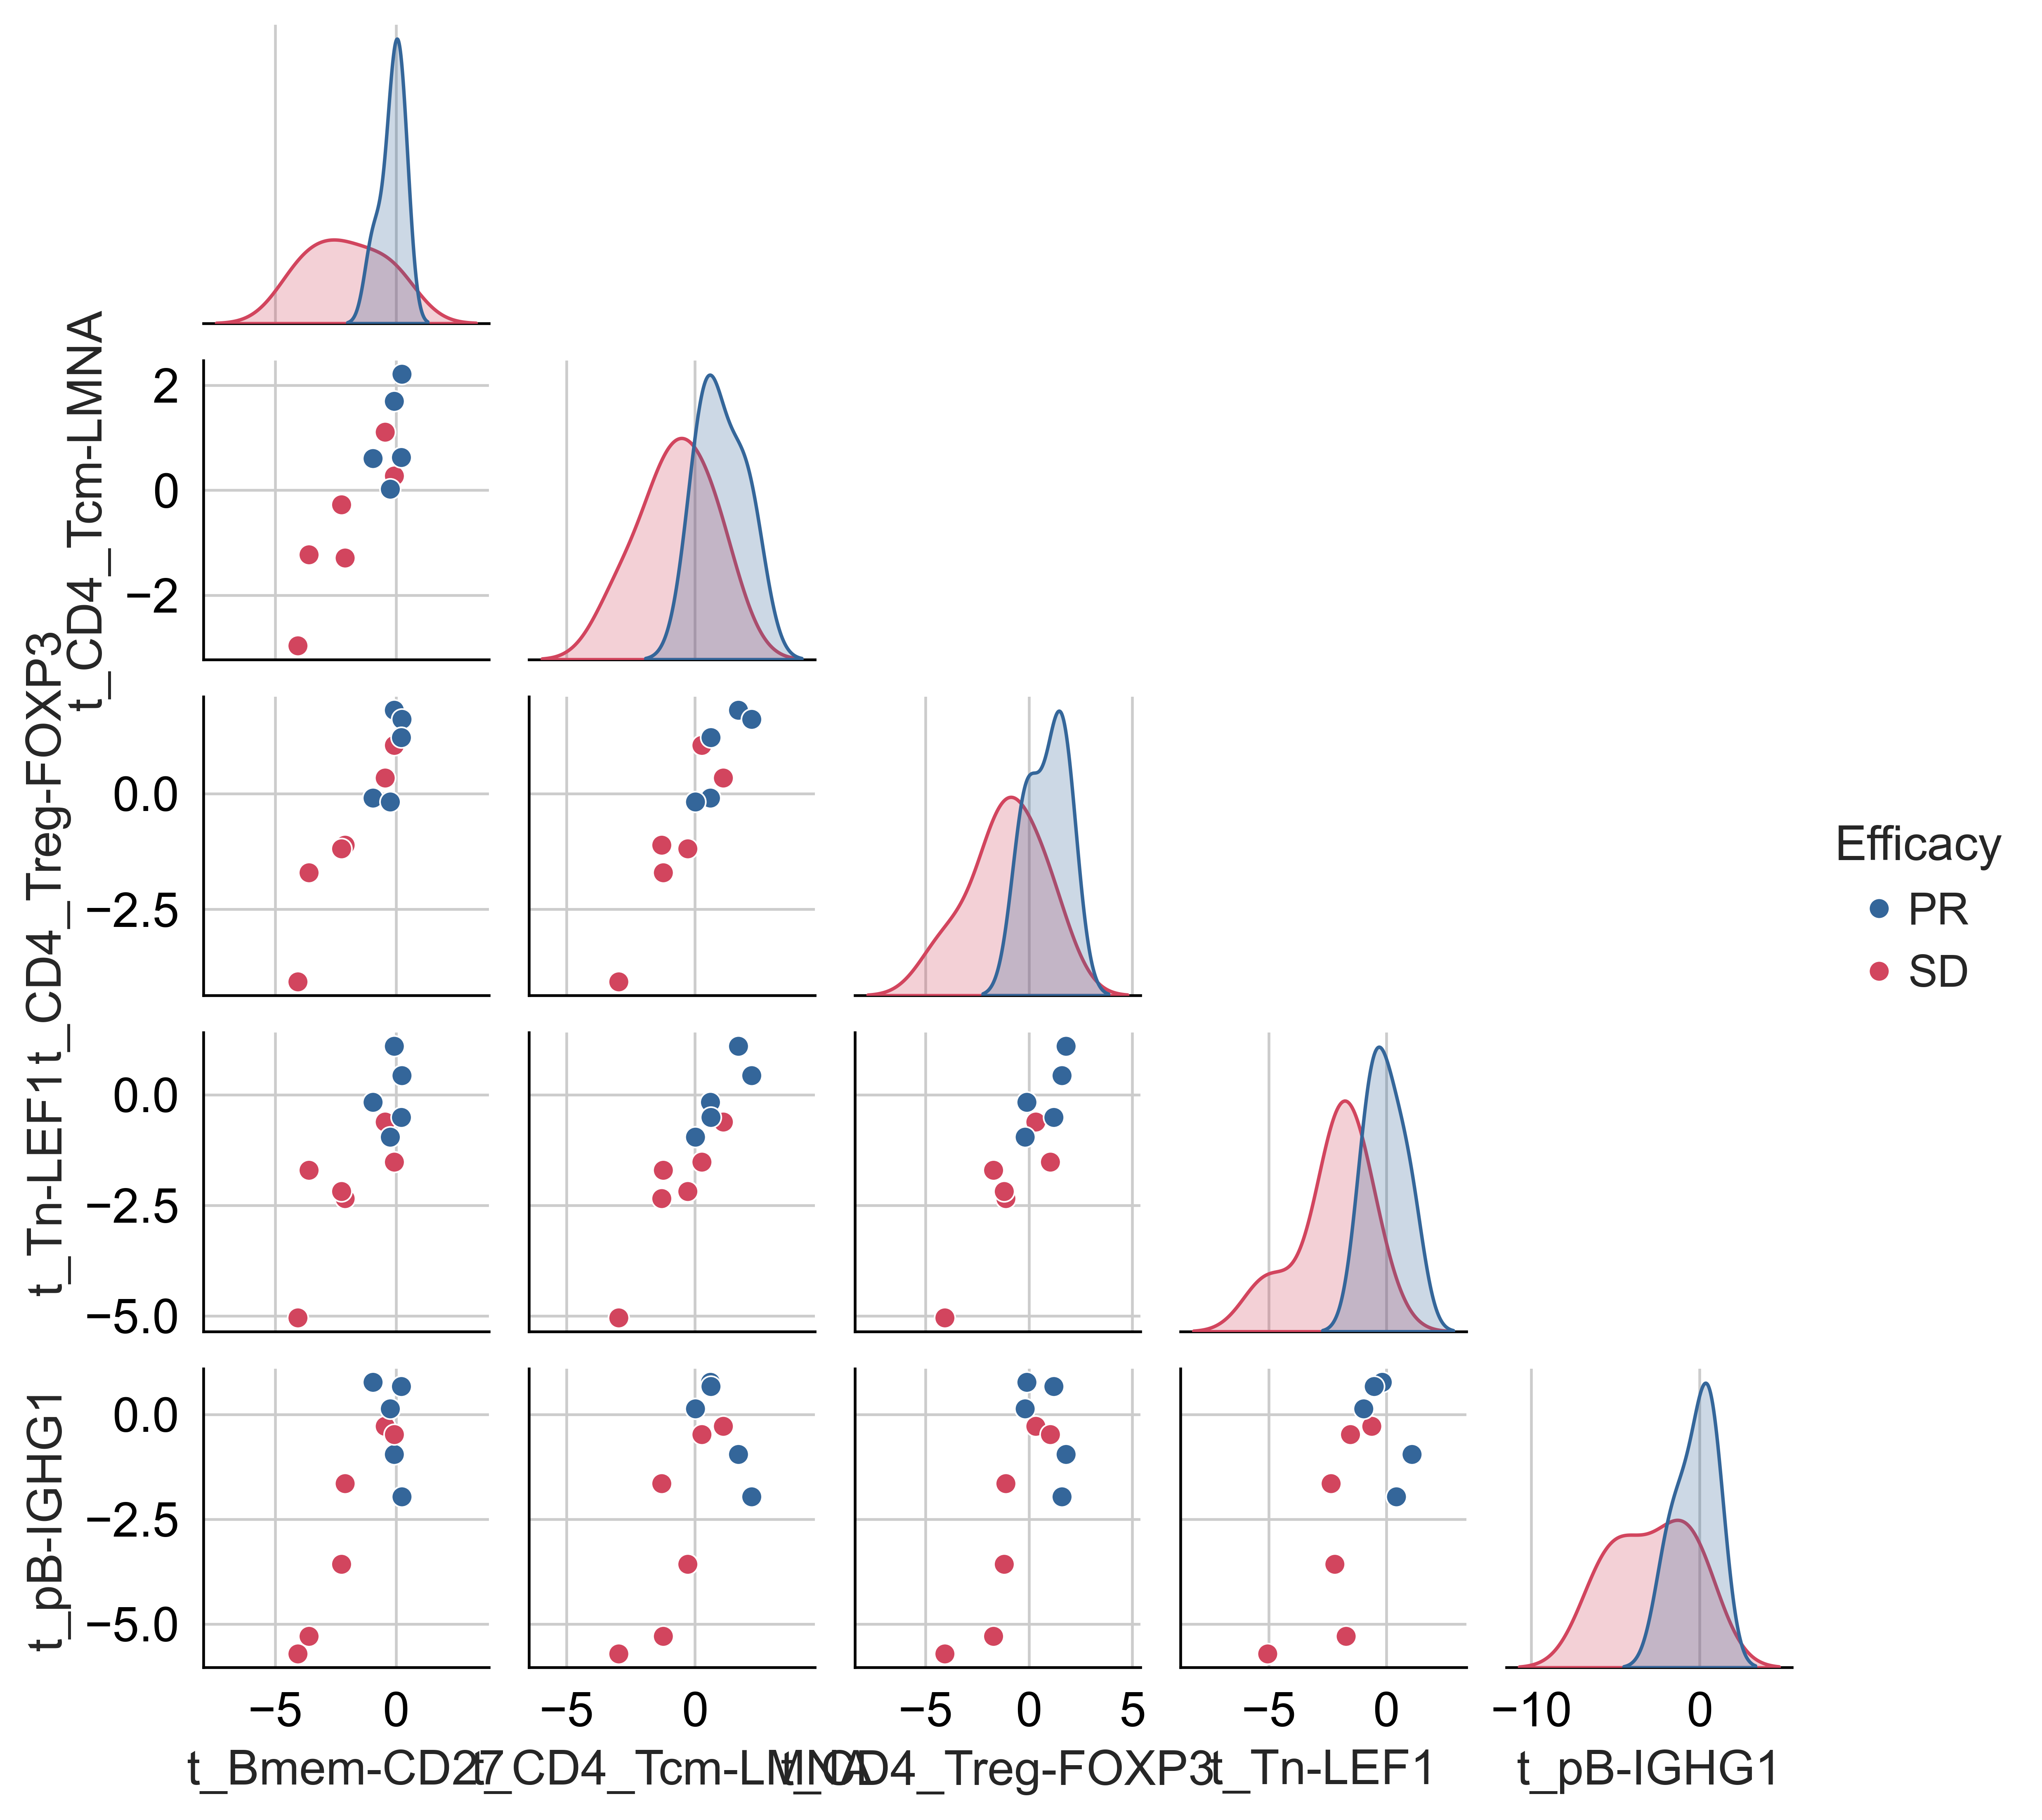

In [11]:
cell_types = ["t_Bmem-CD27", "t_CD4_Tcm-LMNA", "t_CD4_Treg-FOXP3", "t_Tn-LEF1", "t_pB-IGHG1"]

plot_df = {cell_type: [] for cell_type in cell_types}
plot_df["Efficacy"] = []

for sample in adata.obs["Sample"].unique():
    efficacy = adata[adata.obs["Sample"] == sample].obs["Efficacy"].unique()[0]
    plot_df["Efficacy"].append(efficacy)
    for cell_type in cell_types:
        plot_df[cell_type].append(adata[(adata.obs["Sample"] == sample) & (adata.obs["Cluster"] == cell_type)].obs["mcp_1"].mean())
      
plot_df = pd.DataFrame(plot_df)
sns.pairplot(plot_df,
             hue="Efficacy",
             corner=True,
             height=1.5,
             palette = {"SD": common_config.pt_red,"PR": common_config.pt_blue},
             )   
plt.savefig("figures/mcp_pairplot_main.pdf", bbox_inches="tight")

In [12]:
cell_types = associations_df.index

plot_df = {cell_type: [] for cell_type in cell_types}
plot_df["Efficacy"] = []

for sample in adata.obs["Sample"].unique():
    efficacy = adata[adata.obs["Sample"] == sample].obs["Efficacy"].unique()[0]
    plot_df["Efficacy"].append(efficacy)
    for cell_type in cell_types:
        plot_df[cell_type].append(adata[(adata.obs["Sample"] == sample) & (adata.obs["Cluster"] == cell_type)].obs["mcp_1"].mean())
        
plot_df = pd.DataFrame(plot_df)

sns.pairplot(plot_df,
             hue="Efficacy",
             corner=True, 
             height=1.5,
             palette = {"SD": common_config.pt_red,"PR": common_config.pt_blue},
             )
plt.savefig("figures/mcp_pairplot_supp.pdf", bbox_inches="tight")

In [15]:
# Pairplot with four groups (including treatment information)
cell_types = associations_df.index

adata.obs["Efficacy_and_Treatment"] = adata.obs["Efficacy"].astype(str) + " " + adata.obs["Treatment"].astype(str)

plot_df = {cell_type: [] for cell_type in cell_types}
plot_df["Efficacy_and_Treatment"] = []

for sample in adata.obs["Sample"].unique():
    efficacy = adata[adata.obs["Sample"] == sample].obs["Efficacy_and_Treatment"].unique()
    assert len(efficacy) == 1
    efficacy = efficacy[0]
    plot_df["Efficacy_and_Treatment"].append(efficacy)
    for cell_type in cell_types:
        plot_df[cell_type].append(adata[(adata.obs["Sample"] == sample) & (adata.obs["Cluster"] == cell_type)].obs["mcp_1"].mean())
        
plot_df = pd.DataFrame(plot_df)

sns.pairplot(plot_df,
             hue="Efficacy_and_Treatment",
             corner=True, 
             height=1.5,
             )
plt.savefig("figures/mcp_pairplot_supp_four_groups.pdf", bbox_inches="tight")

# Extrema gene plots

In [37]:
def plot_extrema_genes(cell_type, ylim_top=None):
    extrema_genes = pd.read_csv(f"dialogue_output/LP_{cell_type}.csv")
        
    extrema_genes = extrema_genes.sort_values("scores", ascending=False)
    extrema_genes = pd.concat((extrema_genes.head(5), extrema_genes.tail(5)))
    
    # make scatter plot
    plt.figure(figsize=(2.5, 3))
    plt.scatter(range(extrema_genes.shape[0]), extrema_genes["scores"], s=0)
    for i, txt in enumerate(extrema_genes["names"]):
        plt.annotate(txt, (i, extrema_genes["scores"].iloc[i]), rotation=90)
        
    plt.title(cell_type)
    if ylim_top is not None:
        plt.ylim(top=ylim_top)
    plt.xlim(right=10.2)
    plt.ylabel("MCP 2 Score")
    plt.xlabel("Ranking")
    plt.savefig(f"figures/extrema_genes_{cell_type}.pdf", bbox_inches="tight")
    plt.show()

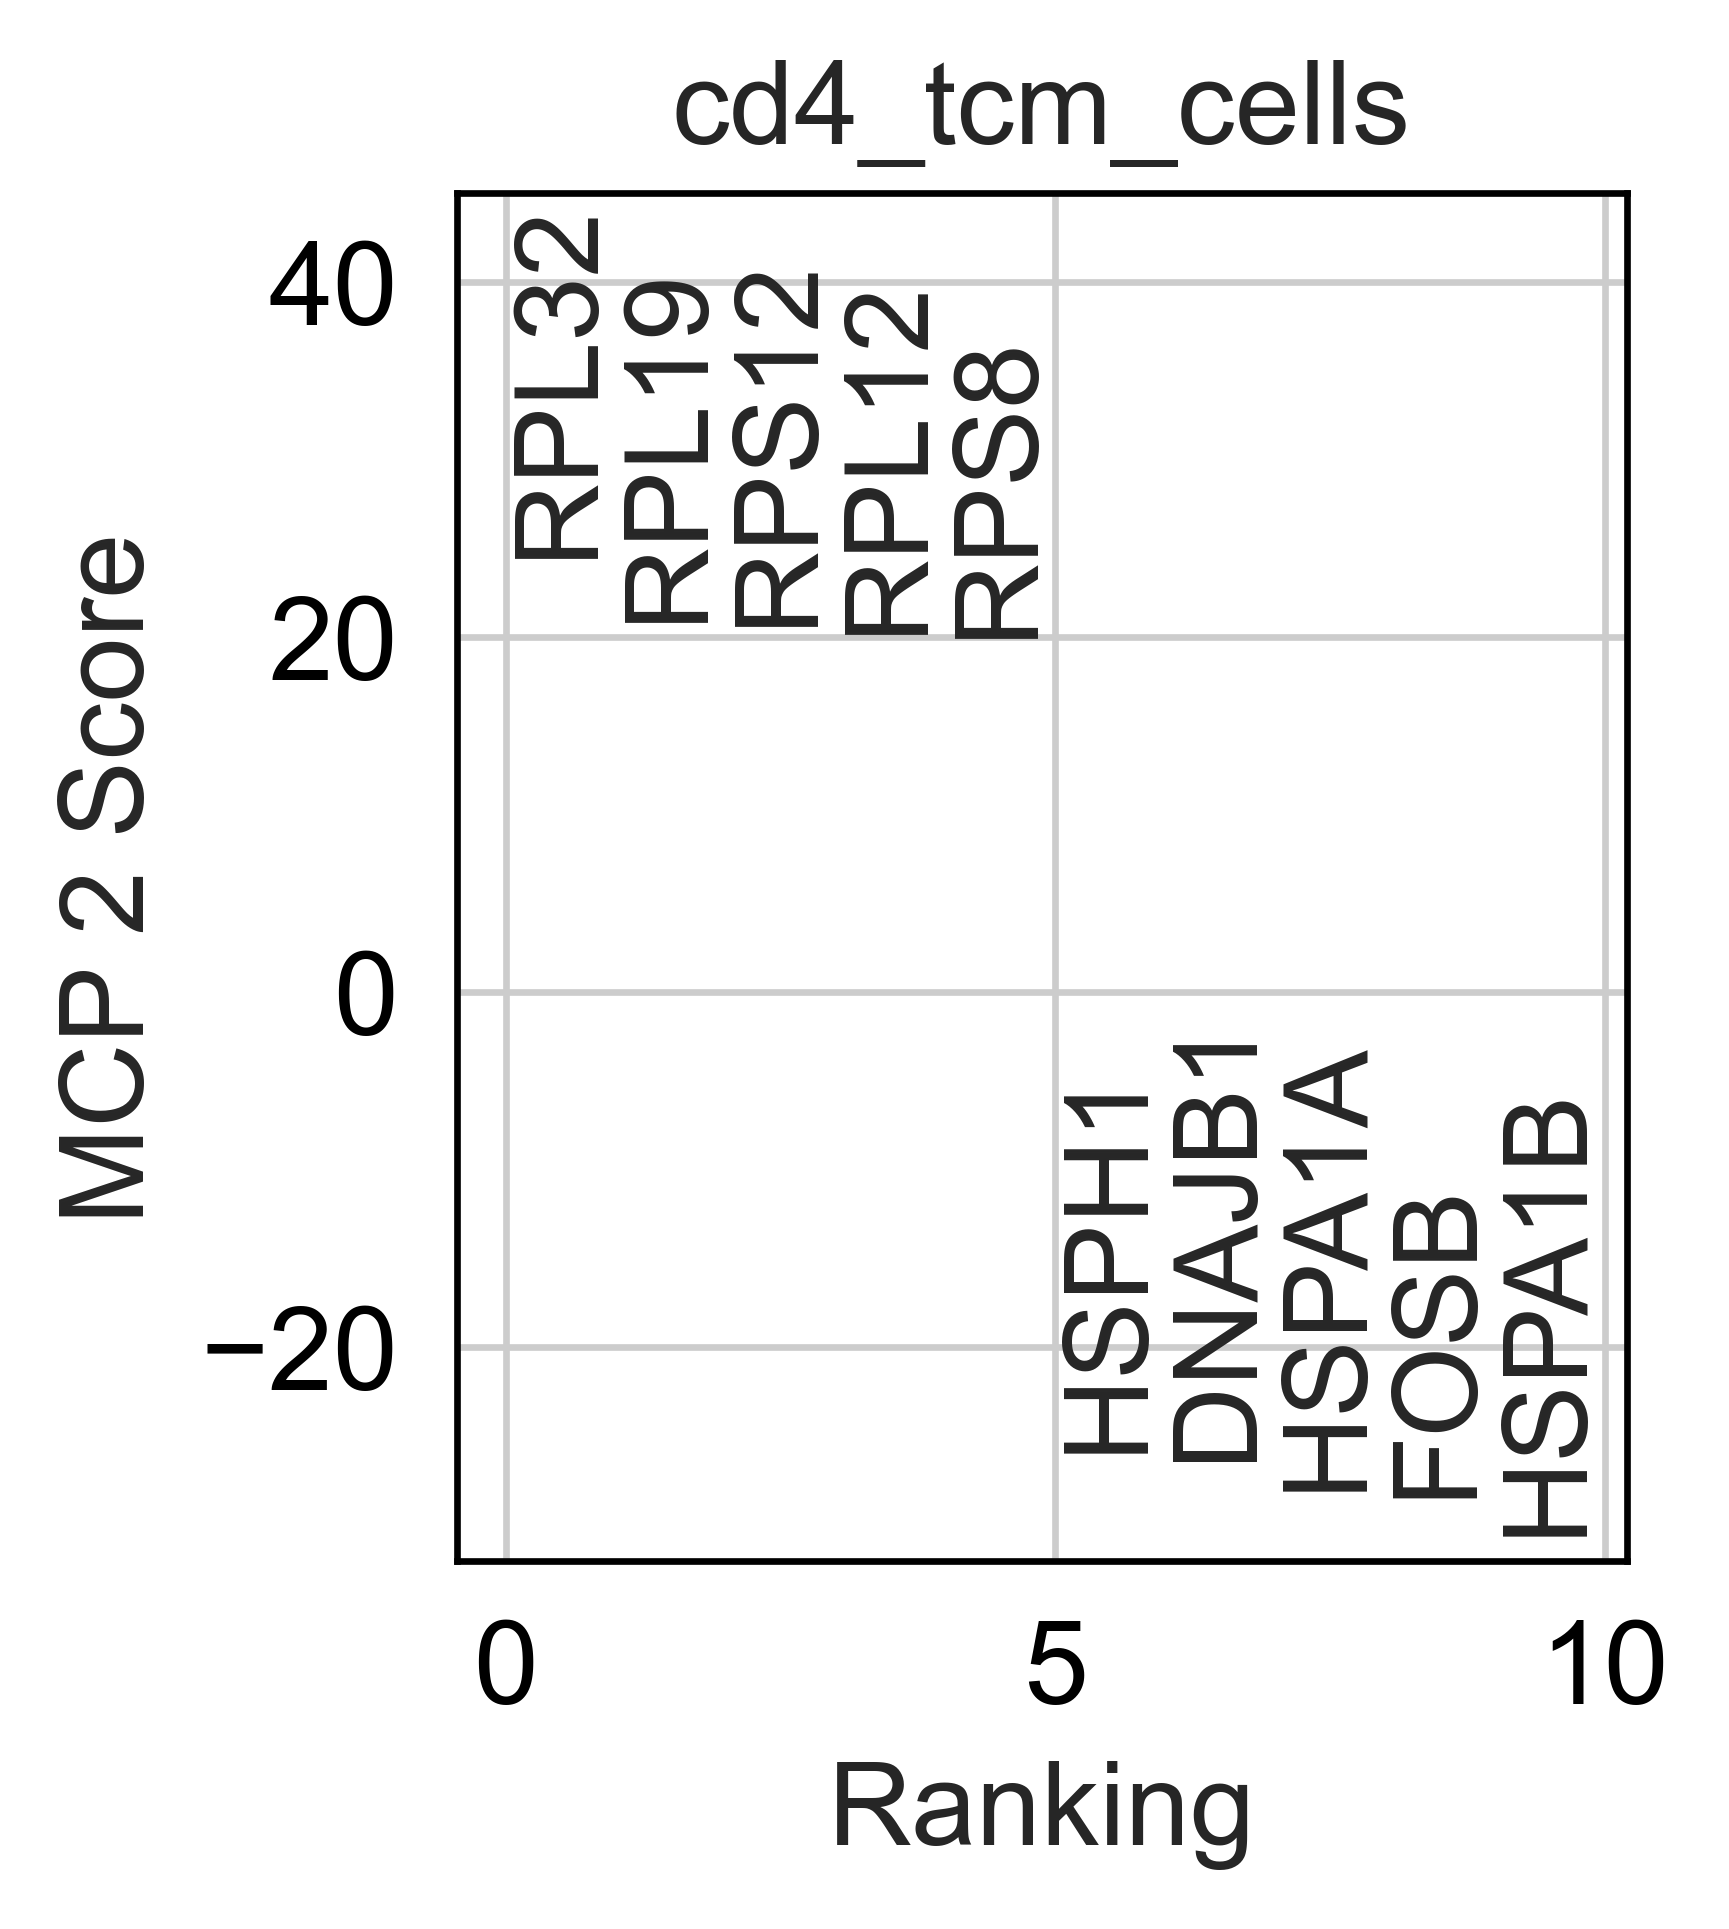

In [40]:
plot_extrema_genes("cd4_tcm_cells", ylim_top=45)

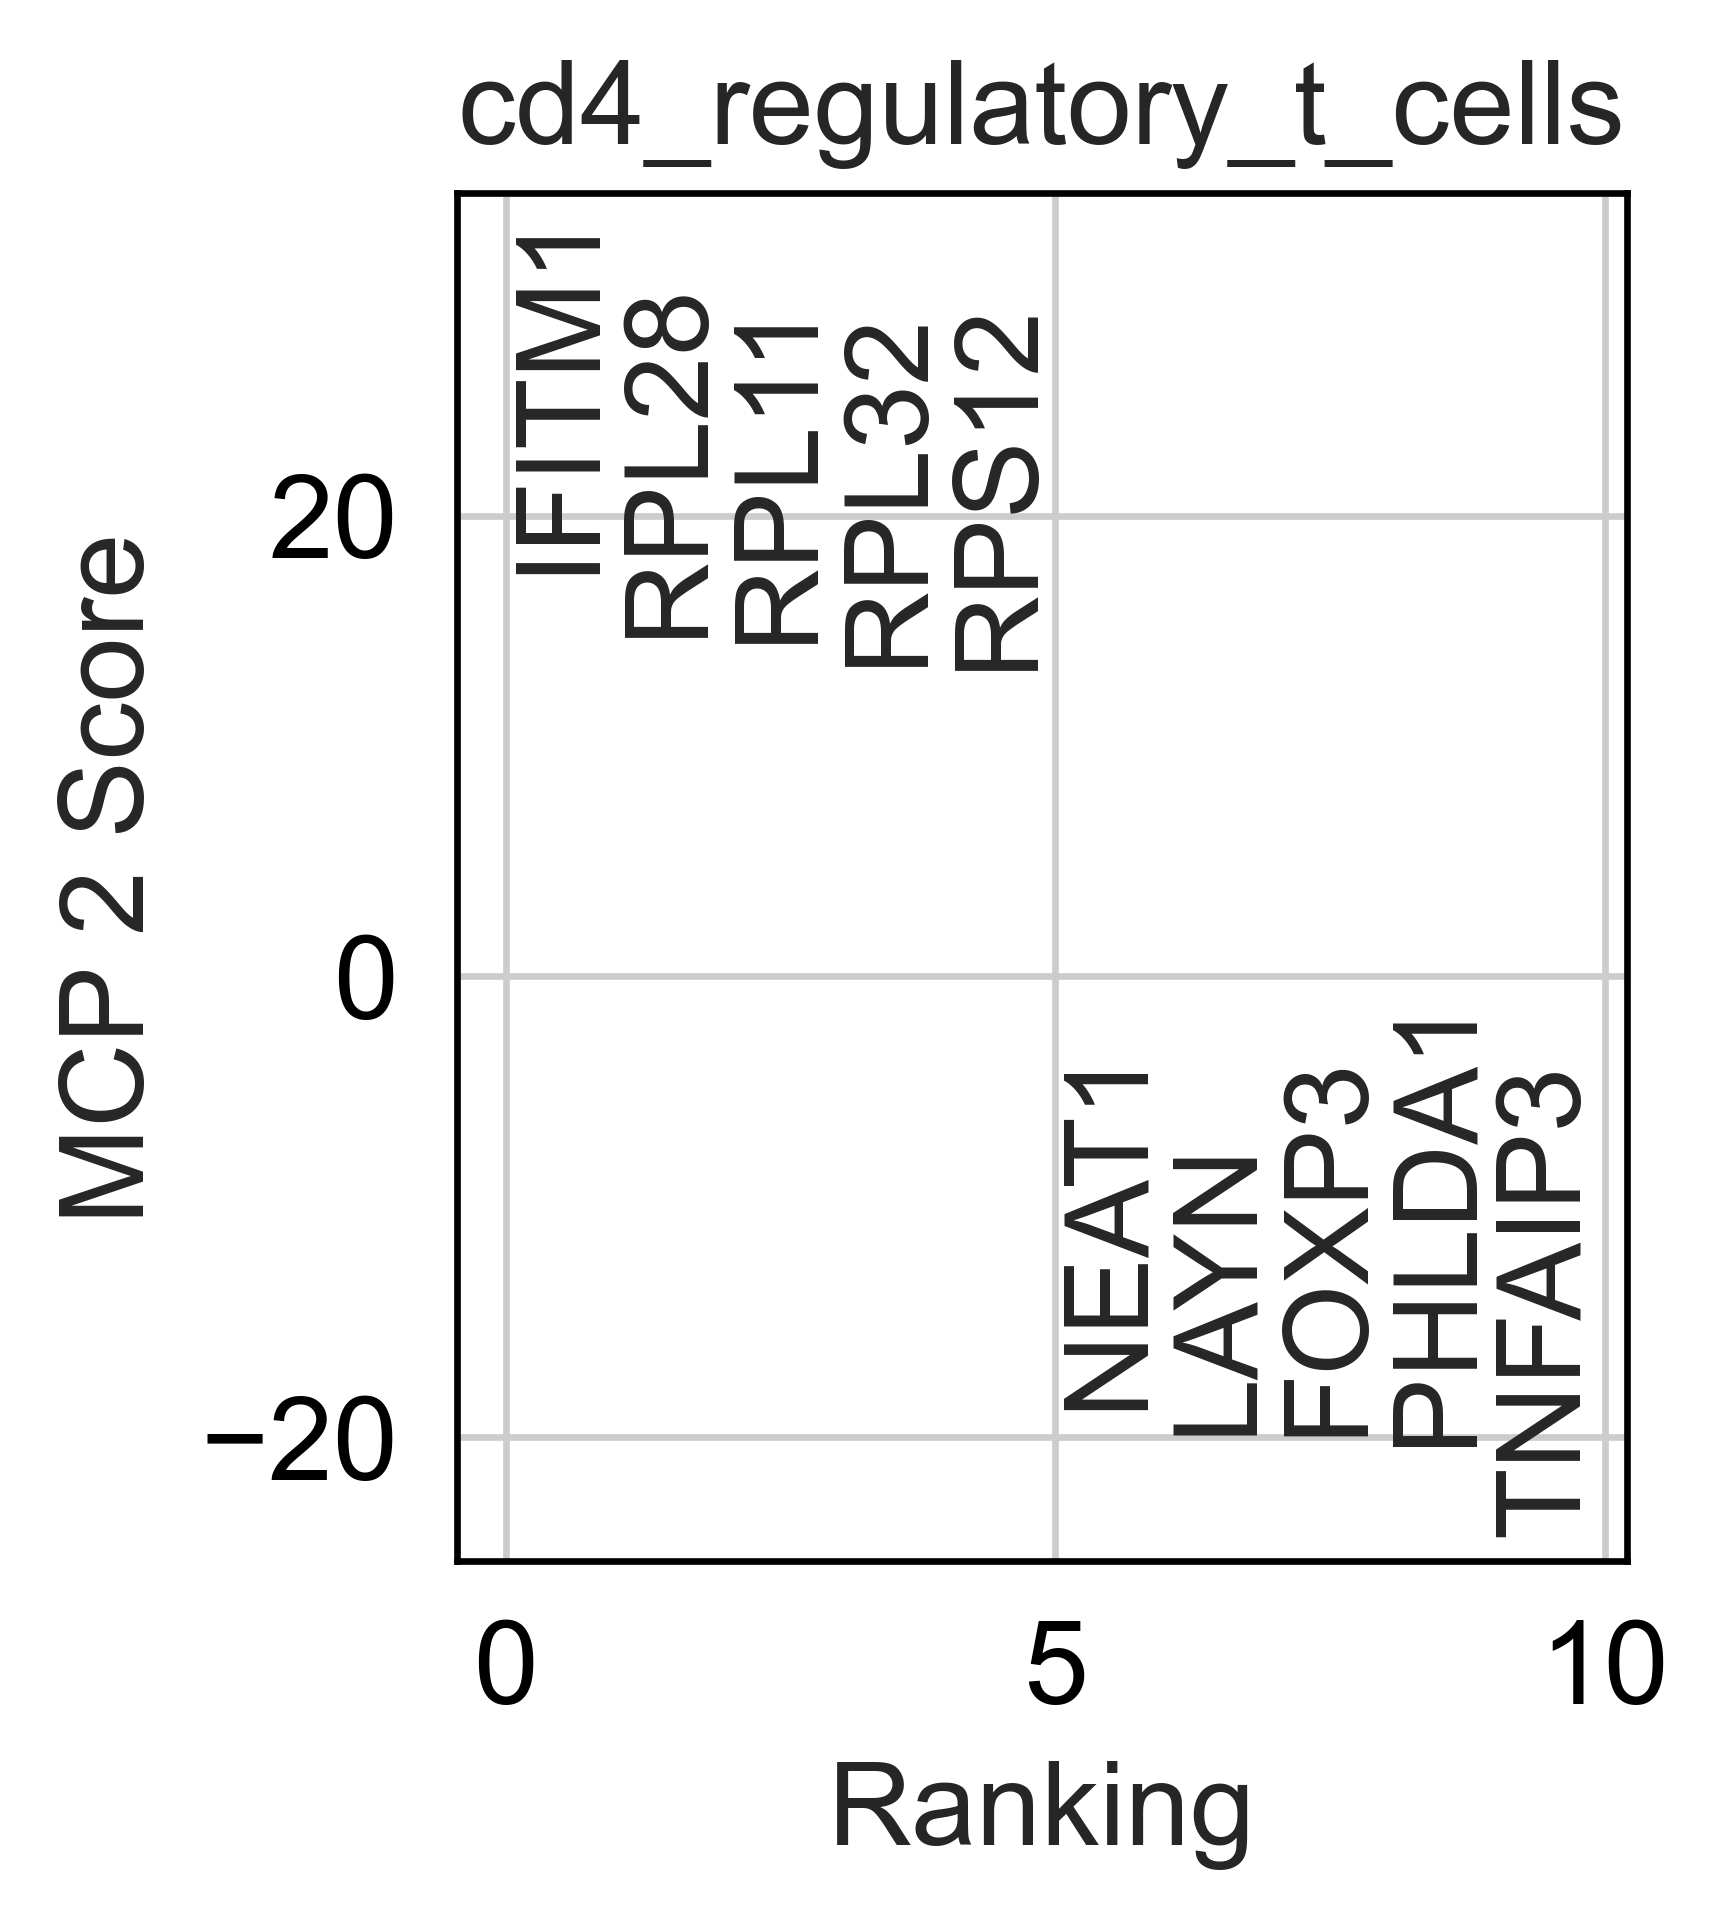

In [42]:
plot_extrema_genes("cd4_regulatory_t_cells", ylim_top=34)

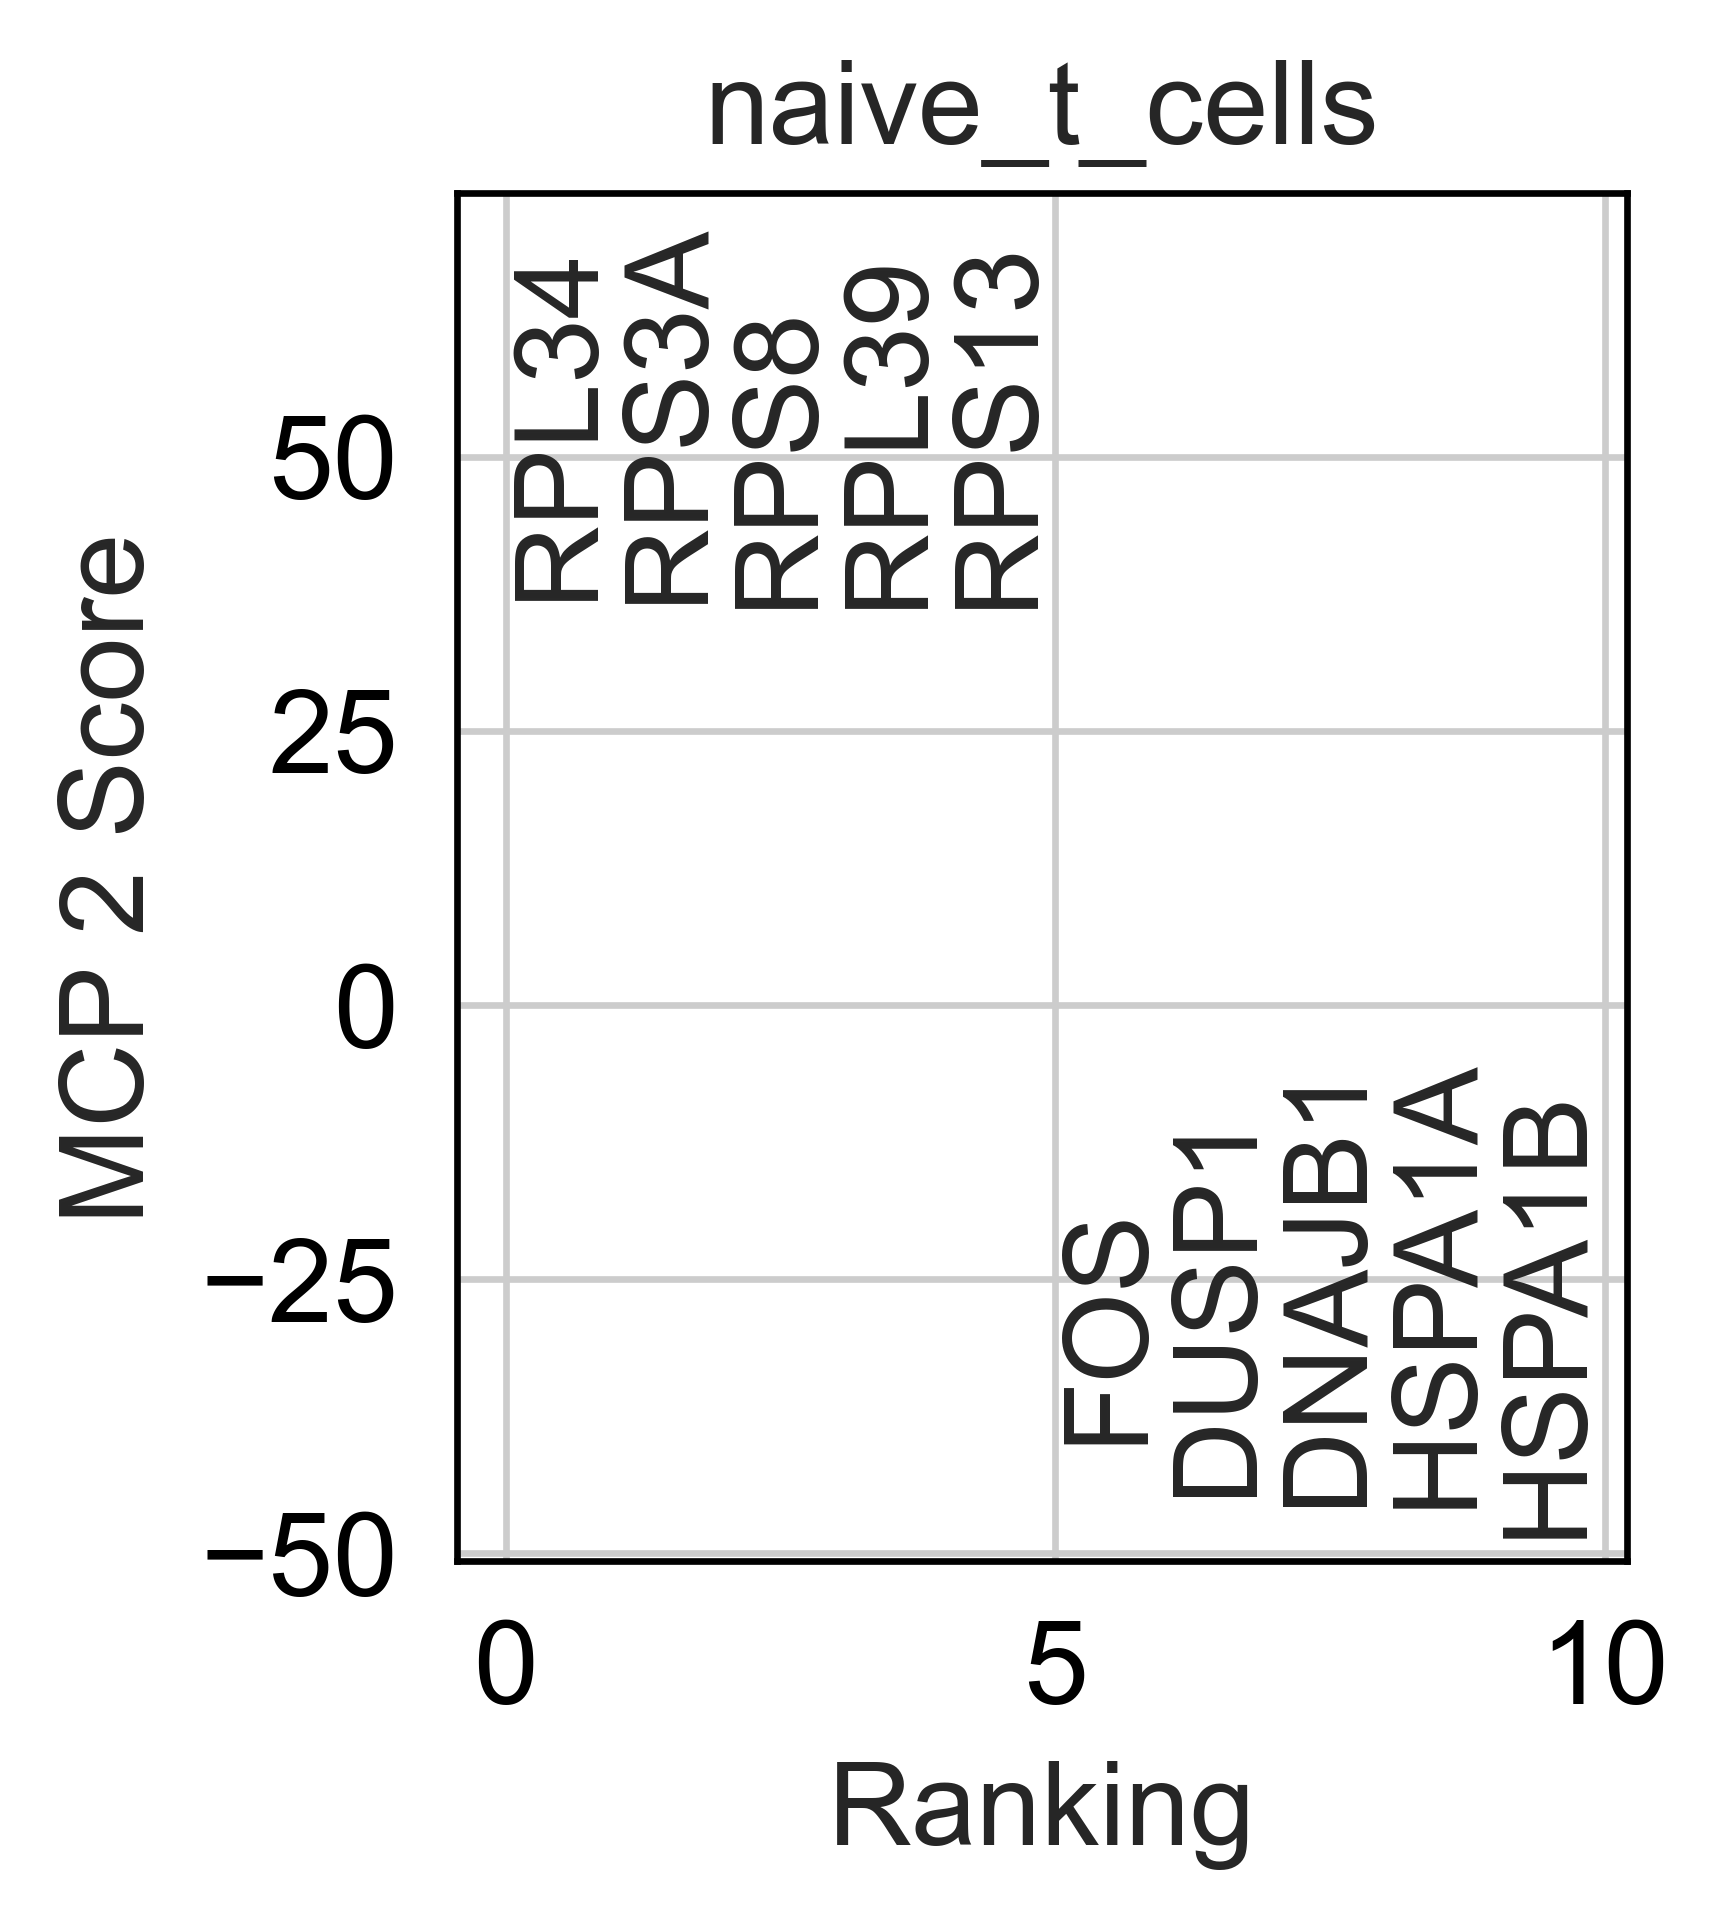

In [51]:
plot_extrema_genes("naive_t_cells", ylim_top=74)

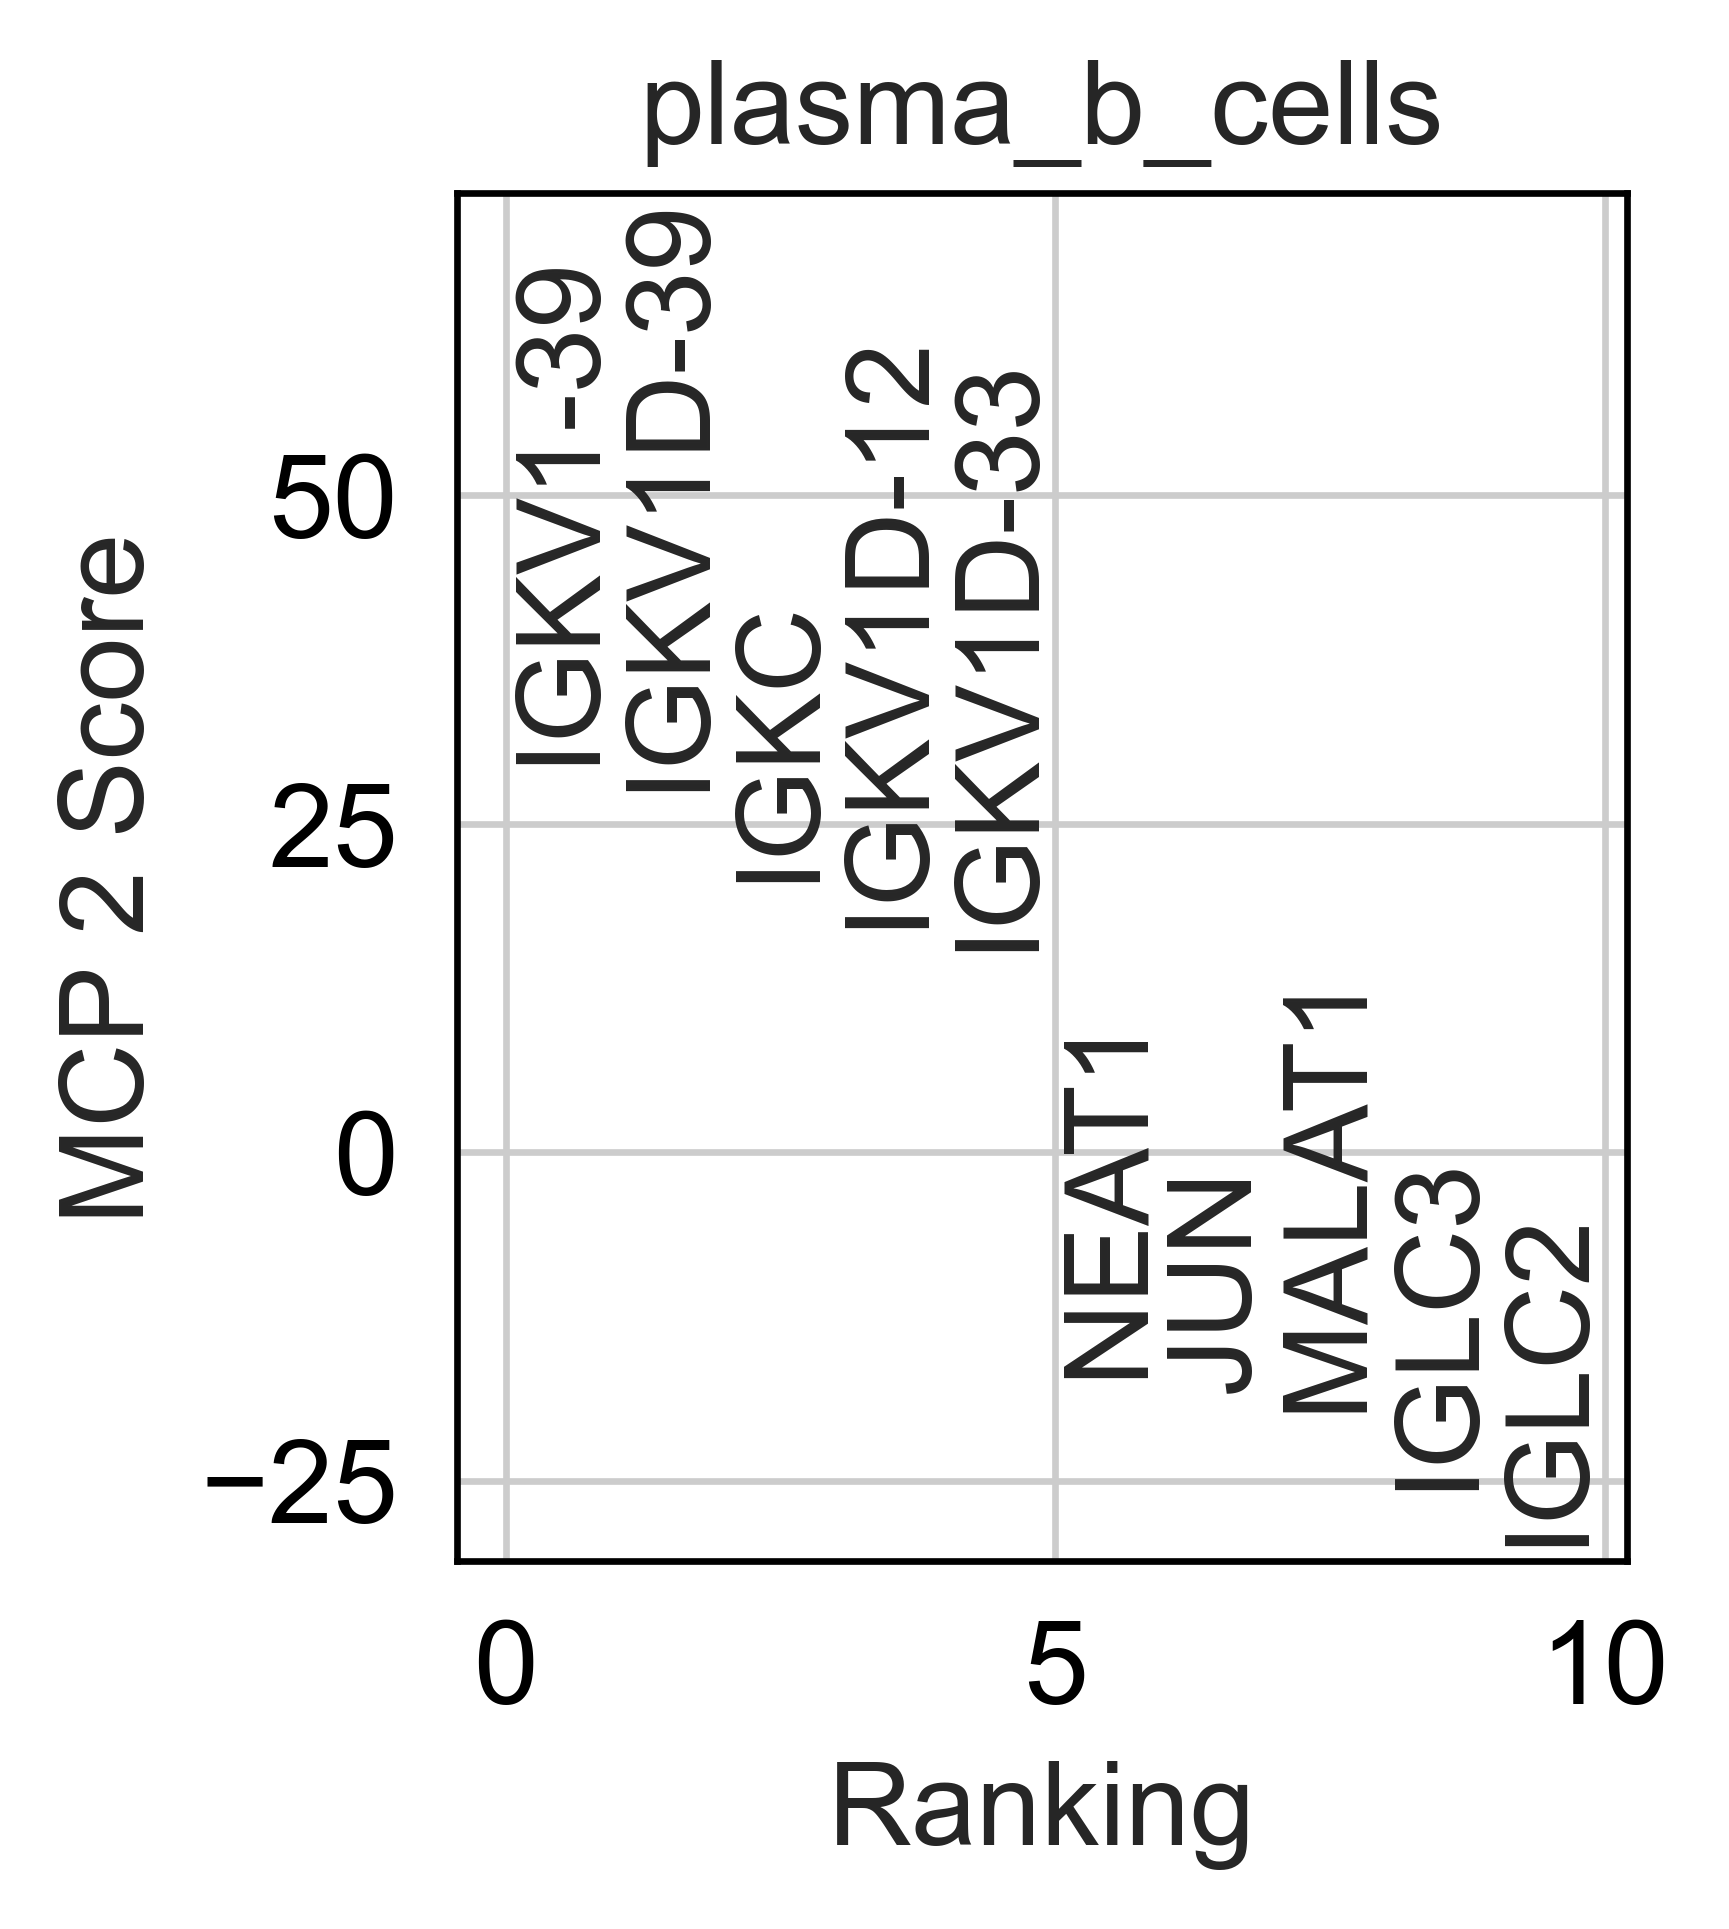

In [48]:
plot_extrema_genes("plasma_b_cells", ylim_top=73)

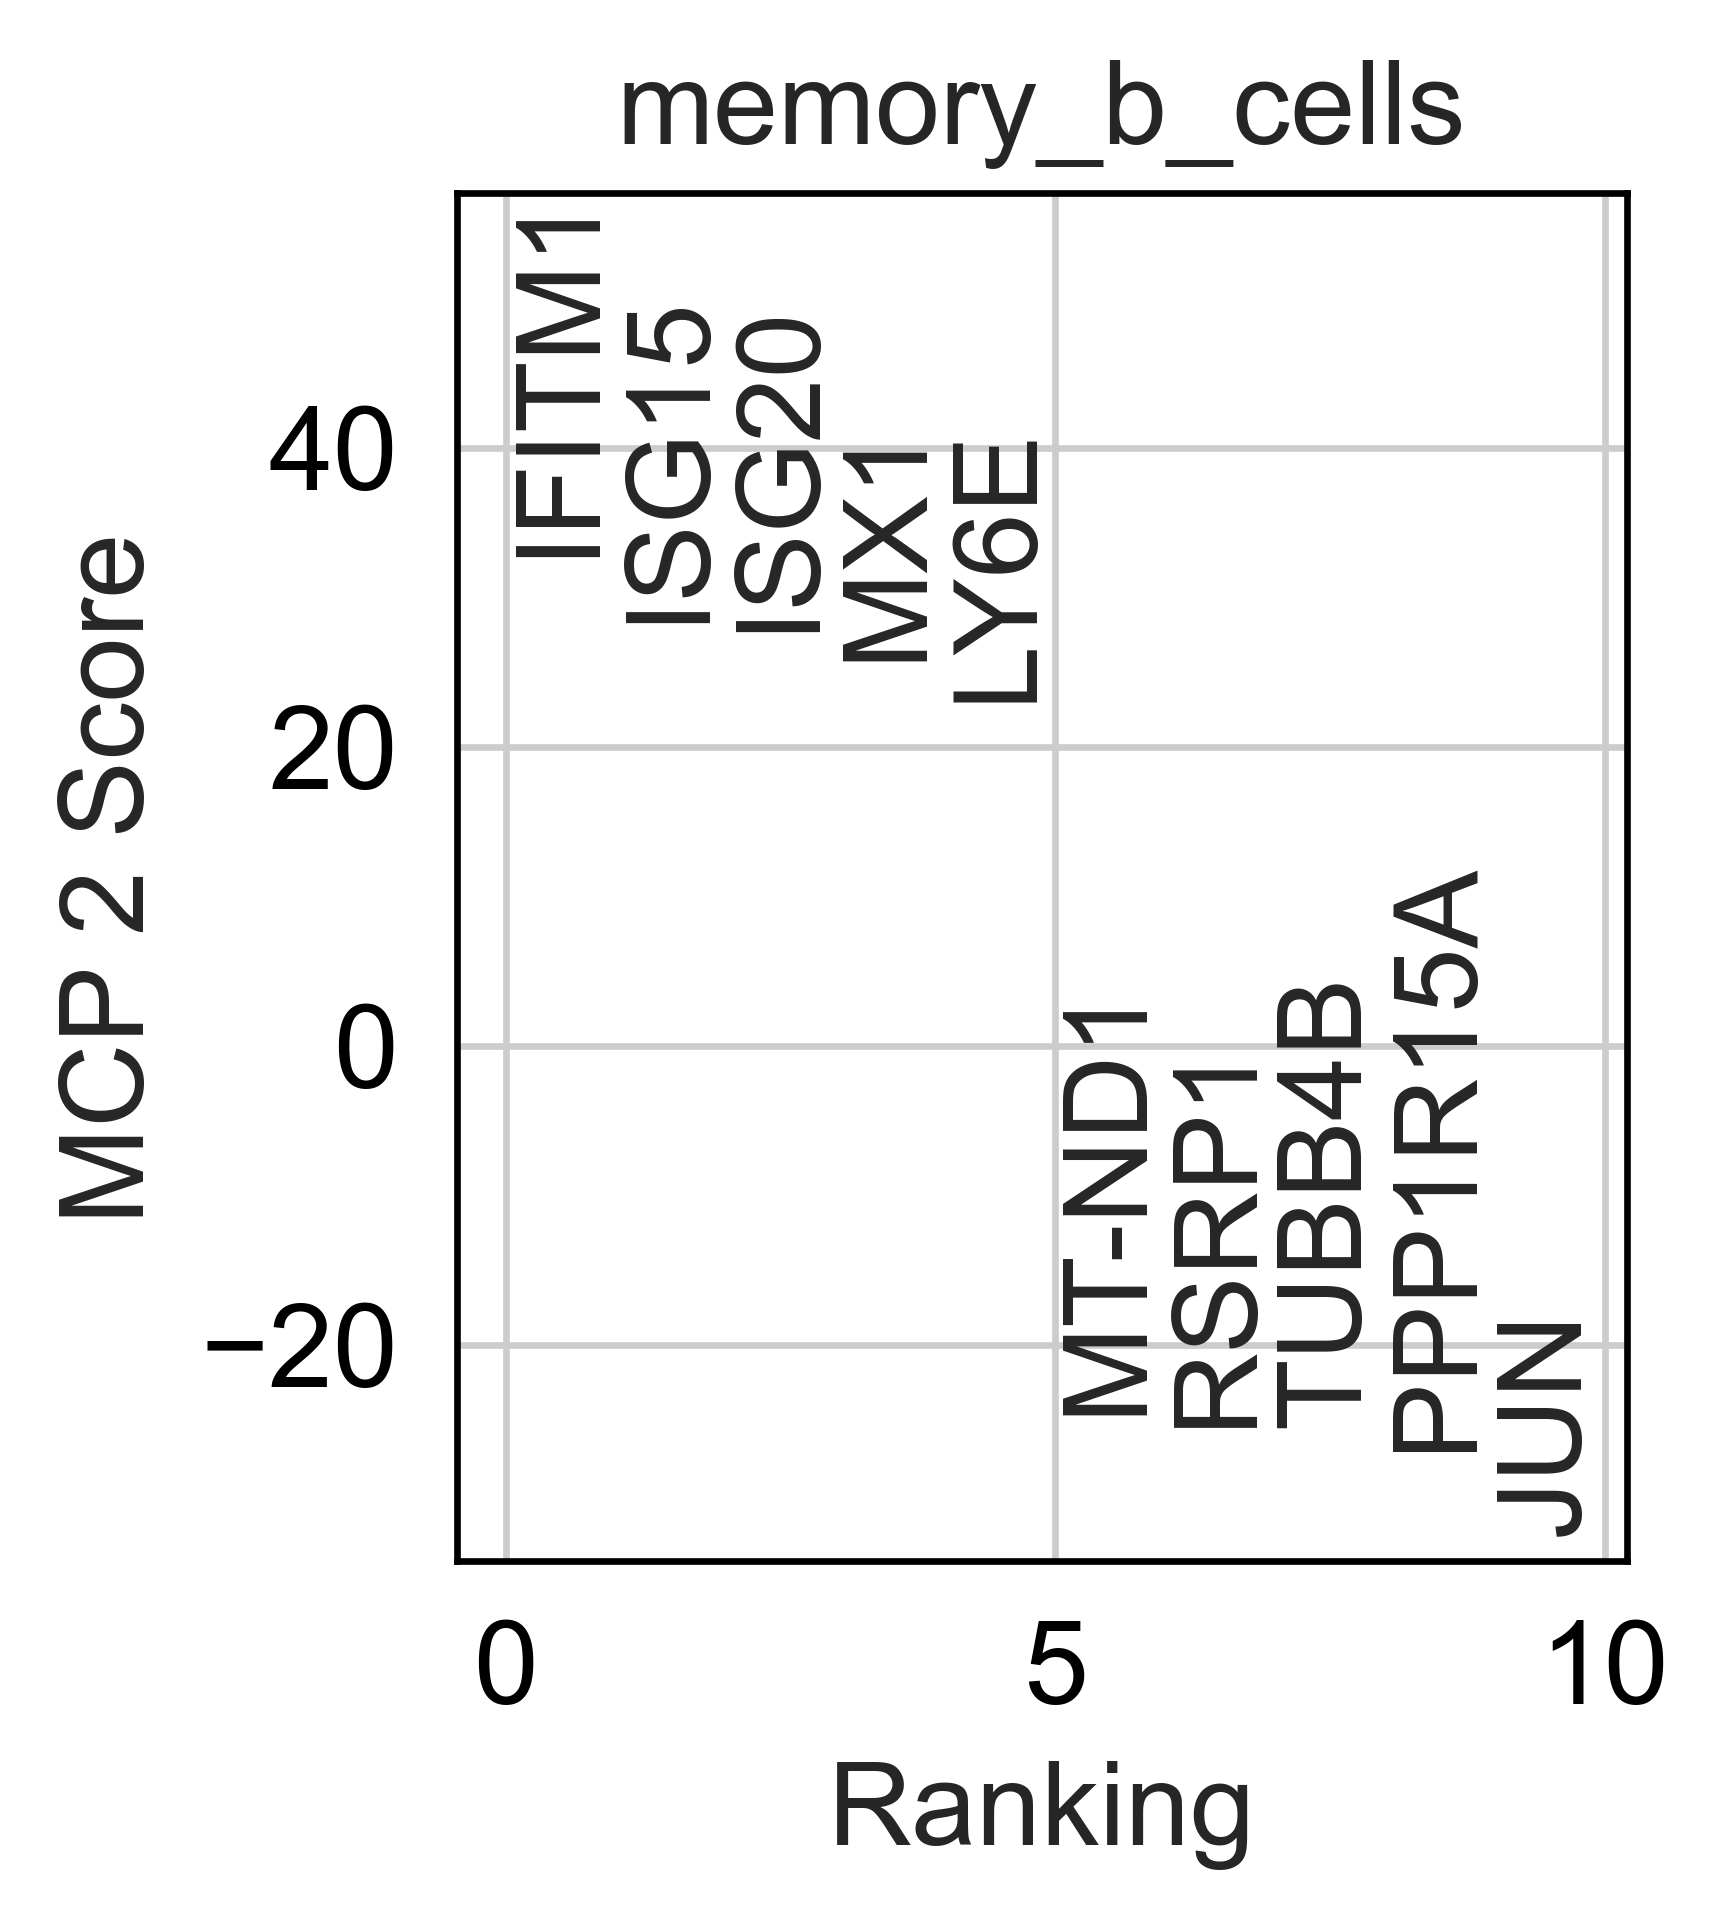

In [50]:
plot_extrema_genes("memory_b_cells", ylim_top=57)